# Module 2 - EDA

## Import libraries

In [ ]:
import os
import boto3
import logging
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv

import seaborn as sns
import matplotlib.pyplot as plt

logging.basicConfig(
    level=logging.INFO,  # Info level for general information
    format="%(asctime)s - %(levelname)s - %(message)s",
)

## Download datasets

In [6]:
# Load environment variables
load_dotenv()
AWW_API_KEY = os.getenv("AWW_API_KEY")
AWW_SECRET = os.getenv("AWW_SECRET")

# Initialize S3 client
s3 = boto3.client(
    's3',
    aws_access_key_id=AWW_API_KEY,
    aws_secret_access_key=AWW_SECRET
)
bucket_name = 'zrive-ds-data'

# Prefixes to fetch
prefixes = [
    "groceries/sampled-datasets/",
    "groceries/box_builder_dataset/"
]

# Local folder
PROJECT_ROOT = Path().resolve().parent.parent
DATA_DIR = PROJECT_ROOT / "data"
DATA_DIR.mkdir(exist_ok=True)

logging.info(f"Data folder: {DATA_DIR}")

for prefix in prefixes:
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

    for obj in response.get("Contents", []):
        file_key = obj["Key"]
        if file_key.endswith("/"):  # skip folder placeholders
            continue

        # Strip the first folder ('groceries/') and keep the inner folders
        relative_path = Path(*file_key.split("/")[1:])
        local_path = DATA_DIR / relative_path
        local_path.parent.mkdir(parents=True, exist_ok=True)

        if local_path.exists():
            logging.info(f"Already exists: {local_path}, skipping download.")
        else:
            s3.download_file(bucket_name, file_key, str(local_path))
            logging.info(f"Downloaded {local_path}")

2025-10-03 11:17:10,671 - INFO - Data folder: /Users/maria/Desktop/Zrive DS/zrive-ds/data


2025-10-03 11:17:11,164 - INFO - Already exists: /Users/maria/Desktop/Zrive DS/zrive-ds/data/sampled-datasets/abandoned_carts.parquet, skipping download.
2025-10-03 11:17:11,166 - INFO - Already exists: /Users/maria/Desktop/Zrive DS/zrive-ds/data/sampled-datasets/inventory.parquet, skipping download.
2025-10-03 11:17:11,167 - INFO - Already exists: /Users/maria/Desktop/Zrive DS/zrive-ds/data/sampled-datasets/orders.parquet, skipping download.
2025-10-03 11:17:11,168 - INFO - Already exists: /Users/maria/Desktop/Zrive DS/zrive-ds/data/sampled-datasets/regulars.parquet, skipping download.
2025-10-03 11:17:11,169 - INFO - Already exists: /Users/maria/Desktop/Zrive DS/zrive-ds/data/sampled-datasets/users.parquet, skipping download.
2025-10-03 11:17:11,235 - INFO - Already exists: /Users/maria/Desktop/Zrive DS/zrive-ds/data/box_builder_dataset/feature_frame.csv, skipping download.


## Load datasets

In [7]:
datasets_path = DATA_DIR / "sampled-datasets"

abandoned_carts_df = pd.read_parquet(datasets_path / "abandoned_carts.parquet")
inventory_df = pd.read_parquet(datasets_path / "inventory.parquet")
orders_df = pd.read_parquet(datasets_path / "orders.parquet")
regulars_df = pd.read_parquet(datasets_path / "regulars.parquet")
users_df = pd.read_parquet(datasets_path / "users.parquet")

logging.info("Datasets loaded successfully.")

2025-10-03 11:17:11,396 - INFO - Datasets loaded successfully.


## Understanding the problem space

### Abandoned carts

In this dataset we obtain the products that were abandoned in the cart, the user who did it and the time.

In [8]:
abandoned_carts_df.head()

,id,user_id,created_at,variant_id
0,12858560217220,5c4e5953f13ddc3bc9659a3453356155e5efe4739d7a2b...,2020-05-20 13:53:24,"[33826459287684, 33826457616516, 3366719212762..."
13,20352449839236,9d6187545c005d39e44d0456d87790db18611d7c7379bd...,2021-06-27 05:24:13,"[34415988179076, 34037940158596, 3450282236326..."
45,20478401413252,e83fb0273d70c37a2968fee107113698fd4f389c442c0b...,2021-07-18 08:23:49,"[34543001337988, 34037939372164, 3411360609088..."
50,20481783103620,10c42e10e530284b7c7c50f3a23a98726d5747b8128084...,2021-07-18 21:29:36,"[33667268116612, 34037940224132, 3443605520397..."
52,20485321687172,d9989439524b3f6fc4f41686d043f315fb408b954d6153...,2021-07-19 12:17:05,"[33667268083844, 34284950454404, 33973246886020]"


In [ ]:
print("Abandoned Carts DataFrame shape:", abandoned_carts_df.shape)
print("Missing values in Abandoned Carts DataFrame:\n", abandoned_carts_df.isnull().sum())

Abandoned Carts DataFrame shape: (5457, 4)
Missing values in Abandoned Carts DataFrame:
 id            0
user_id       0
created_at    0
variant_id    0
dtype: int64


In [24]:
print("Unique users in Abandoned Carts DataFrame:", abandoned_carts_df['user_id'].nunique())

Unique users in Abandoned Carts DataFrame: 3439


### Inventory

In this dataset we get information about each product (variant_id).

In [9]:
inventory_df.head()

,variant_id,price,compare_at_price,vendor,product_type,tags
0,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]"
1,34370361229444,4.99,5.50,whogivesacrap,toilet-roll-kitchen-roll-tissue,"[b-corp, eco, toilet-rolls]"
2,34284951863428,3.69,3.99,plenty,toilet-roll-kitchen-roll-tissue,[kitchen-roll]
3,33667283583108,1.79,1.99,thecheekypanda,toilet-roll-kitchen-roll-tissue,"[b-corp, cruelty-free, eco, tissue, vegan]"
4,33803537973380,1.99,2.09,colgate,dental,[dental-accessories]


In [15]:
print("Inventory DataFrame shape:", inventory_df.shape)
print("Missing values in Inventory DataFrame:\n", inventory_df.isnull().sum())

Inventory DataFrame shape: (1733, 6)
Missing values in Inventory DataFrame:
 variant_id          0
price               0
compare_at_price    0
vendor              0
product_type        0
tags                0
dtype: int64


In [16]:
inventory_df.describe(include='all')

,variant_id,price,compare_at_price,vendor,product_type,tags
count,1.733000e+03,1733.000000,1733.000000,1733,1733,1733
unique,NaN,NaN,NaN,412,59,1333
top,NaN,NaN,NaN,biona,cleaning-products,[sponges-cloths-gloves]
freq,NaN,NaN,NaN,69,160,18
mean,3.694880e+13,6.307351,7.028881,NaN,NaN,NaN
std,2.725674e+12,7.107218,7.660542,NaN,NaN,NaN
min,3.361529e+13,0.000000,0.000000,NaN,NaN,NaN
25%,3.427657e+13,2.490000,2.850000,NaN,NaN,NaN
50%,3.927260e+13,3.990000,4.490000,NaN,NaN,NaN
75%,3.948318e+13,7.490000,8.210000,NaN,NaN,NaN


In [23]:
print("Duplicated variant_ids in Inventory DataFrame:", inventory_df['variant_id'].duplicated().sum())

Duplicated variant_ids in Inventory DataFrame: 0


### Orders

This one is list of the products ordered by a user.

In [10]:
orders_df.head()

,id,user_id,created_at,order_date,user_order_seq,ordered_items
10,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,"[33618849693828, 33618860179588, 3361887404045..."
20,2204707520644,bf591c887c46d5d3513142b6a855dd7ffb9cc00697f6f5...,2020-04-30 17:39:00,2020-04-30,1,"[33618835243140, 33618835964036, 3361886244058..."
21,2204838822020,329f08c66abb51f8c0b8a9526670da2d94c0c6eef06700...,2020-04-30 18:12:30,2020-04-30,1,"[33618891145348, 33618893570180, 3361889766618..."
34,2208967852164,f6451fce7b1c58d0effbe37fcb4e67b718193562766470...,2020-05-01 19:44:11,2020-05-01,1,"[33618830196868, 33618846580868, 3361891234624..."
49,2215889436804,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,2020-05-03 21:56:14,2020-05-03,1,"[33667166699652, 33667166699652, 3366717122163..."


In [17]:
print("Orders DataFrame shape:", orders_df.shape)
print("Missing values in Orders DataFrame:\n", orders_df.isnull().sum())

Orders DataFrame shape: (8773, 6)
Missing values in Orders DataFrame:
 id                0
user_id           0
created_at        0
order_date        0
user_order_seq    0
ordered_items     0
dtype: int64


In [22]:
print("Unique users in Orders DataFrame:", orders_df['user_id'].nunique())

Unique users in Orders DataFrame: 4983


### Regulars

Here we obtain the moment when a product was marked as regular by a user.

In [11]:
regulars_df.head()

,user_id,variant_id,created_at
3,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33618848088196,2020-04-30 15:07:03
11,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667178659972,2020-05-05 23:34:35
18,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,33619009208452,2020-04-30 15:07:03
46,aed88fc0b004270a62ff1fe4b94141f6b1db1496dbb0c0...,33667305373828,2020-05-05 23:34:35
47,4594e99557113d5a1c5b59bf31b8704aafe5c7bd180b32...,33667247341700,2020-05-06 14:42:11


In [19]:
print("Regulars DataFrame shape:", regulars_df.shape)
print("Missing values in Regulars DataFrame:\n", regulars_df.isnull().sum())

Regulars DataFrame shape: (18105, 3)
Missing values in Regulars DataFrame:
 user_id       0
variant_id    0
created_at    0
dtype: int64


In [21]:
print("Unique users in Regulars DataFrame:", regulars_df['user_id'].nunique())

Unique users in Regulars DataFrame: 1448


### Users

In this dataset we have the user information.

In [12]:
users_df.head()

,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets
2160,0e823a42e107461379e5b5613b7aa00537a72e1b0eaa7a...,Top Up,UKH,2021-05-08 13:33:49,2021-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1123,15768ced9bed648f745a7aa566a8895f7a73b9a47c1d4f...,Top Up,UKJ,2021-11-17 16:30:20,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1958,33e0cb6eacea0775e34adbaa2c1dec16b9d6484e6b9324...,Top Up,UKD,2022-03-09 23:12:25,2022-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN
675,57ca7591dc79825df0cecc4836a58e6062454555c86c35...,Top Up,UKI,2021-04-23 16:29:02,2021-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN
4694,085d8e598139ce6fc9f75d9de97960fa9e1457b409ec00...,Top Up,UKJ,2021-11-02 13:50:06,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN


In [18]:
print("Users DataFrame shape:", users_df.shape)
print("Missing values in Users DataFrame:\n", users_df.isnull().sum())

Users DataFrame shape: (4983, 10)
Missing values in Users DataFrame:
 user_id                     0
user_segment                0
user_nuts1                 51
first_ordered_at            0
customer_cohort_month       0
count_people             4658
count_adults             4658
count_children           4658
count_babies             4658
count_pets               4658
dtype: int64


In [20]:
users_df.describe(include='all')

,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets
count,4983,4983,4932,4983,4983,325.000000,325.000000,325.000000,325.000000,325.000000
unique,4983,2,12,4982,24,NaN,NaN,NaN,NaN,NaN
top,d96aadc220f2776037e519f2c3bd4a2f0199658cc45b29...,Top Up,UKI,2021-11-03 19:51:46,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
freq,1,2643,1318,2,688,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,2.787692,2.003077,0.707692,0.076923,0.636923
std,NaN,NaN,NaN,NaN,NaN,1.365753,0.869577,1.026246,0.289086,0.995603
min,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,2.000000,2.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,3.000000,2.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,NaN,NaN,NaN,4.000000,2.000000,1.000000,0.000000,1.000000


In [64]:
print("Users per segment:\n", users_df['user_segment'].value_counts())
print("\nUsers per nuts1 region:\n", users_df['user_nuts1'].value_counts())

Users per segment:
 user_segment
Top Up         2643
Proposition    2340
Name: count, dtype: int64

Users per nuts1 region:
 user_nuts1
UKI    1318
UKJ     745
UKK     602
UKH     414
UKD     358
UKM     315
UKE     303
UKG     295
UKF     252
UKL     224
UKC     102
UKN       4
Name: count, dtype: int64


### Abandoned + Inventory

Merging these dataframes we can understand what type of products tend to be abandoned.

In [60]:
abandoned_inventory_df = pd.merge(abandoned_carts_df.explode('variant_id'), inventory_df, left_on='variant_id', right_on='variant_id', how='left')
abandoned_inventory_df.head()

,id,user_id,created_at,variant_id,price,compare_at_price,vendor,product_type,tags
0,12858560217220,5c4e5953f13ddc3bc9659a3453356155e5efe4739d7a2b...,2020-05-20 13:53:24,33826459287684,NaN,NaN,NaN,NaN,NaN
1,12858560217220,5c4e5953f13ddc3bc9659a3453356155e5efe4739d7a2b...,2020-05-20 13:53:24,33826457616516,NaN,NaN,NaN,NaN,NaN
2,12858560217220,5c4e5953f13ddc3bc9659a3453356155e5efe4739d7a2b...,2020-05-20 13:53:24,33667192127620,NaN,NaN,NaN,NaN,NaN
3,12858560217220,5c4e5953f13ddc3bc9659a3453356155e5efe4739d7a2b...,2020-05-20 13:53:24,33826412331140,NaN,NaN,NaN,NaN,NaN
4,12858560217220,5c4e5953f13ddc3bc9659a3453356155e5efe4739d7a2b...,2020-05-20 13:53:24,33826472558724,3.99,4.09,profusion,cooking-ingredients,"[salt-pepper, vegan]"


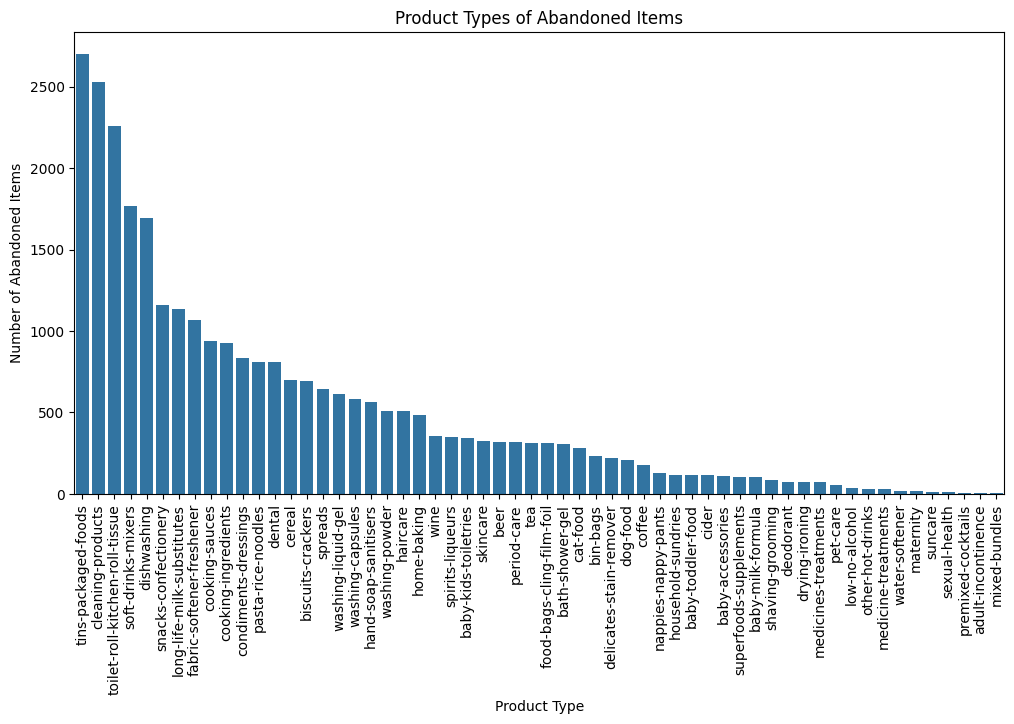

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=abandoned_inventory_df, x='product_type', order=abandoned_inventory_df['product_type'].value_counts().index)
plt.title('Product Types of Abandoned Items')
plt.xlabel('Product Type')
plt.ylabel('Number of Abandoned Items')
plt.xticks(rotation=90)
plt.show()

### Orders + Users

Joining these dataframes can let us know the type of customer that orders more and which type of product.

In [25]:
user_orders_df = pd.merge(orders_df, users_df, on='user_id', how='left')
user_orders_df.head()

,id,user_id,created_at,order_date,user_order_seq,ordered_items,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets
0,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,"[33618849693828, 33618860179588, 3361887404045...",Proposition,UKI,2020-04-30 14:32:19,2020-04-01 00:00:00,4.0,4.0,0.0,0.0,0.0
1,2204707520644,bf591c887c46d5d3513142b6a855dd7ffb9cc00697f6f5...,2020-04-30 17:39:00,2020-04-30,1,"[33618835243140, 33618835964036, 3361886244058...",Proposition,UKM,2020-04-30 17:39:00,2020-04-01 00:00:00,4.0,2.0,2.0,0.0,1.0
2,2204838822020,329f08c66abb51f8c0b8a9526670da2d94c0c6eef06700...,2020-04-30 18:12:30,2020-04-30,1,"[33618891145348, 33618893570180, 3361889766618...",Top Up,UKF,2020-04-30 18:12:30,2020-04-01 00:00:00,4.0,2.0,2.0,0.0,1.0
3,2208967852164,f6451fce7b1c58d0effbe37fcb4e67b718193562766470...,2020-05-01 19:44:11,2020-05-01,1,"[33618830196868, 33618846580868, 3361891234624...",Proposition,UKI,2020-05-01 19:44:11,2020-05-01 00:00:00,4.0,3.0,1.0,0.0,1.0
4,2215889436804,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,2020-05-03 21:56:14,2020-05-03,1,"[33667166699652, 33667166699652, 3366717122163...",Proposition,UKI,2020-05-03 21:56:14,2020-05-01 00:00:00,2.0,2.0,0.0,0.0,0.0


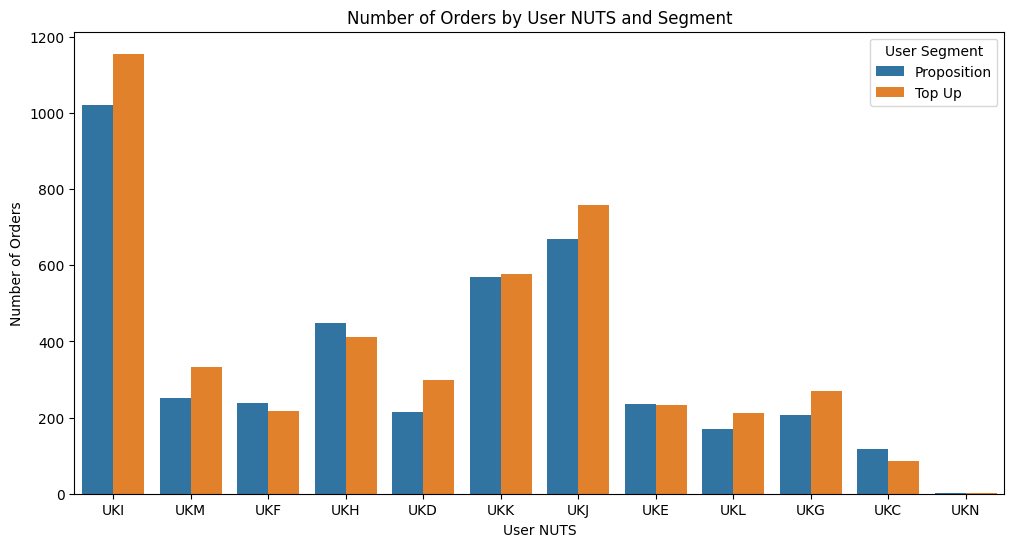

In [ ]:
# Plotting the number of orders by user nuts and segment
plt.figure(figsize=(12, 6))
sns.countplot(data=user_orders_df, x='user_nuts1', hue='user_segment')
plt.title('Number of Orders by User NUTS1 and Segment')
plt.xlabel('User NUTS1')
plt.ylabel('Number of Orders')
plt.legend(title='User Segment')
plt.show()

Here, we can see that London stands out as the region with the highest number of orders, with a significant gap compared to the second-highest region. The other leading regions are also located in the south. Additionally, the majority of orders were placed by Top Up users.

### Orders + Users + Inventory

Before merging, we have to explode the `ordered_items` feature in order to have only one per row.

In [ ]:
user_orders_exploded_df = user_orders_df.explode('ordered_items')
user_orders_inventory_df = pd.merge(user_orders_exploded_df, inventory_df, left_on='ordered_items', right_on='variant_id', how='left')
user_orders_inventory_df.head()

,id,user_id,created_at,order_date,user_order_seq,ordered_items,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,...,count_adults,count_children,count_babies,count_pets,variant_id,price,compare_at_price,vendor,product_type,tags
0,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618849693828,Proposition,UKI,2020-04-30 14:32:19,2020-04-01 00:00:00,...,4.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618860179588,Proposition,UKI,2020-04-30 14:32:19,2020-04-01 00:00:00,...,4.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618874040452,Proposition,UKI,2020-04-30 14:32:19,2020-04-01 00:00:00,...,4.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618907005060,Proposition,UKI,2020-04-30 14:32:19,2020-04-01 00:00:00,...,4.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,33618907005060,Proposition,UKI,2020-04-30 14:32:19,2020-04-01 00:00:00,...,4.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


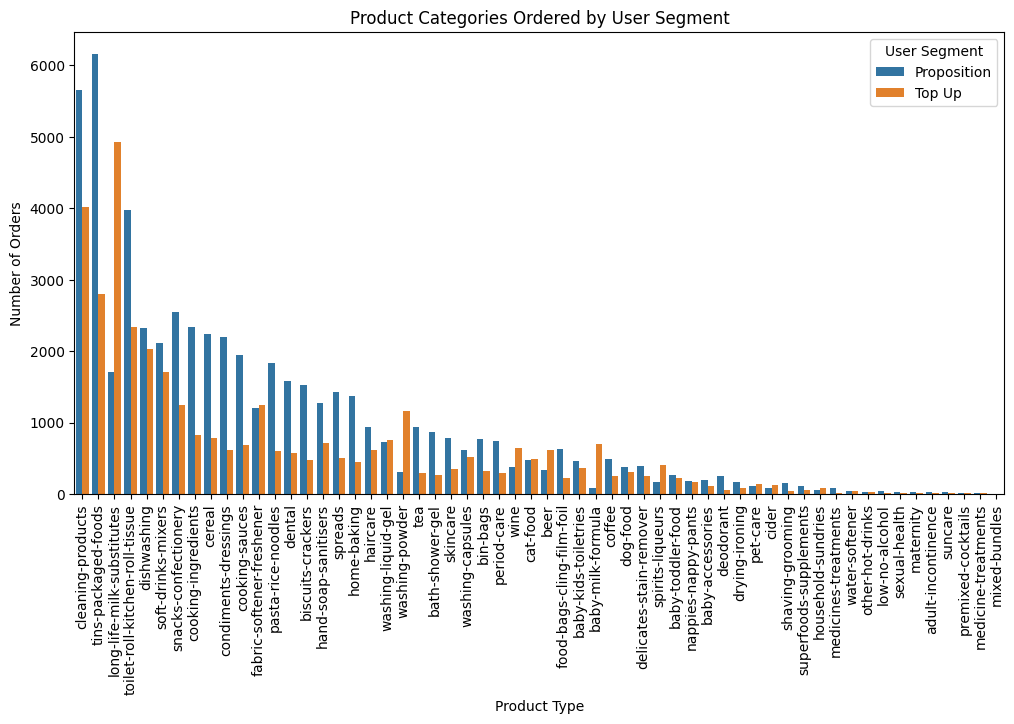

In [44]:
# Plot the distribution of product categories ordered by user segment
plt.figure(figsize=(12, 6))
sns.countplot(data=user_orders_inventory_df, x='product_type', hue='user_segment', order=user_orders_inventory_df['product_type'].value_counts().index)
plt.title('Product Categories Ordered by User Segment')
plt.xlabel('Product Type')
plt.ylabel('Number of Orders')
plt.legend(title='User Segment')
plt.xticks(rotation=90)
plt.show()

Looking at the plot we can see that the most ordered categories were ordered mostly by Proposition Users.

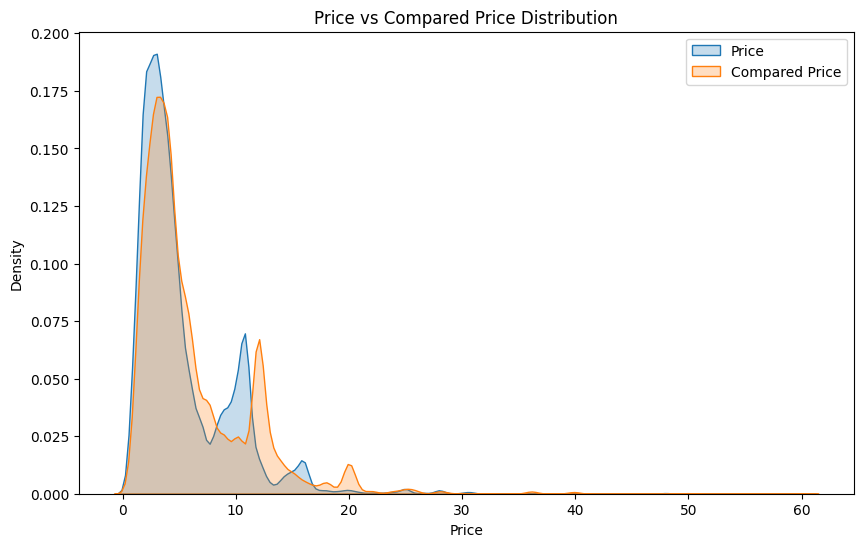

In [58]:
# Compare the price and compared_price distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(user_orders_inventory_df['price'].dropna(), label='Price', fill=True)
sns.kdeplot(user_orders_inventory_df['compare_at_price'].dropna(), label='Compared Price', fill=True)
plt.title('Price vs Compared Price Distribution')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()
plt.show()

Lastly, this plot illustrates that many products are sold below their recommended price, indicating that the store is consistently promoting offers and discounts.